---
title: Reproducing results from the DSE paper
---

This is just the same example you already had in the paper, The main issue/delay in obtaining it was the normalized_ouput parameter in mesolve which should have been set to false.

In order to run the notebook unfortunately both my version of [qutip]() with the fitting stuff and this poorly done package for the [cumulant equation](https://github.com/gsuarezr/NonMarkovianMethods/tree/multiplebaths) needs to be installed  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import ising
from nmm import csolve


In [2]:
N=4
g=1
H,sx,sy,sz=ising(N=N,g=g,Jx=5)

In [3]:
Q=sx[-1]+ 1.1*sy[-1]+0.9*sz[-1]

bath parameters

In [75]:
s=3

In [76]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
gamma=3.8*g
w0=s*E01
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=1.15*np.sqrt(Omega)
lam

True


5.891413893989452

In [77]:
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
times=np.linspace(0,300,500)
tfit=np.linspace(0, 50*s, 5000)

 Using HEOM

In [78]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=3)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 3 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 6.62e-01 |-1.90e+00 |2.62e+01                              | 1         |-6.61e-01 |-1.90e+00 |2.62e+01                              
 2         |-1.26e+01 |-1.66e+01 |3.37e-17                              |                                                                        
 3         | 1.26e+01 |-1.65e+01 |5.67e-01                              |A  normalized RM

In [79]:
times2 = np.linspace(0,50,500)
cvis = bath.correlation_function(times2)

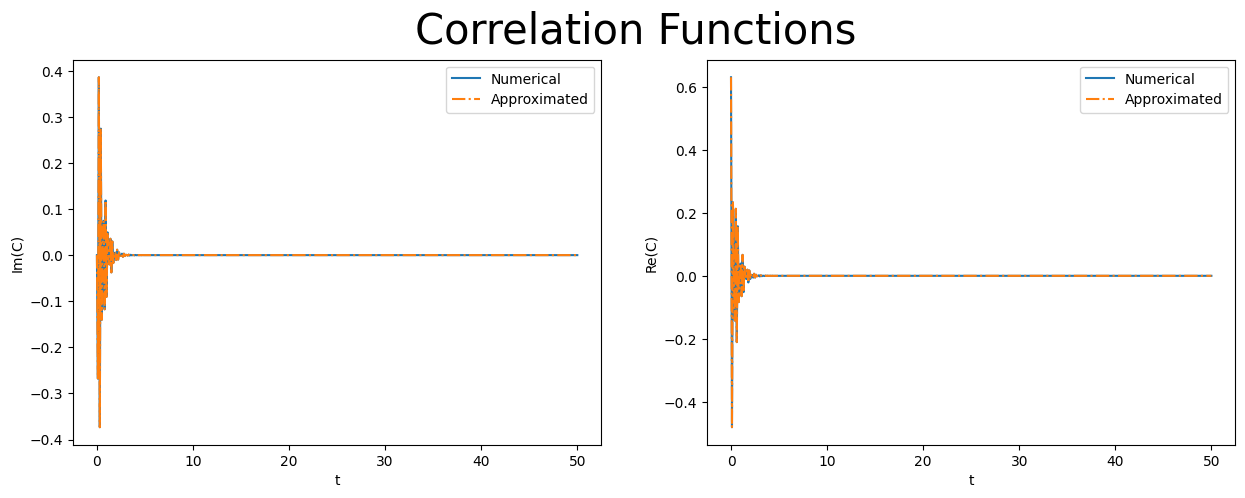

In [80]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [9]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time: 180.01s. Est. time left: 00:00:26:56
20.0%. Run time: 353.30s. Est. time left: 00:00:23:29
30.1%. Run time: 521.95s. Est. time left: 00:00:20:14
40.1%. Run time: 691.89s. Est. time left: 00:00:17:14
50.1%. Run time: 895.19s. Est. time left: 00:00:14:51
60.1%. Run time: 1076.76s. Est. time left: 00:00:11:54
70.1%. Run time: 1250.05s. Est. time left: 00:00:08:52
80.2%. Run time: 1419.10s. Est. time left: 00:00:05:51
90.2%. Run time: 1611.13s. Est. time left: 00:00:02:55
100.0%. Run time: 1789.59s. Est. time left: 00:00:00:00
Total run time: 1789.59s


In [12]:
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)
result_cum = cum.evolution(rho0)


result_cum = rotation(result_cum, H, times)

Computing Exponential of Generators . . . .: 100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.73it/s]


In [13]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-1.95e-02 |-2.93e+00 |7.88e-14                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.41e-02 |-1.42e+01 |5.27e-13                              |                                                                        
                                                                        |A  normalized RM

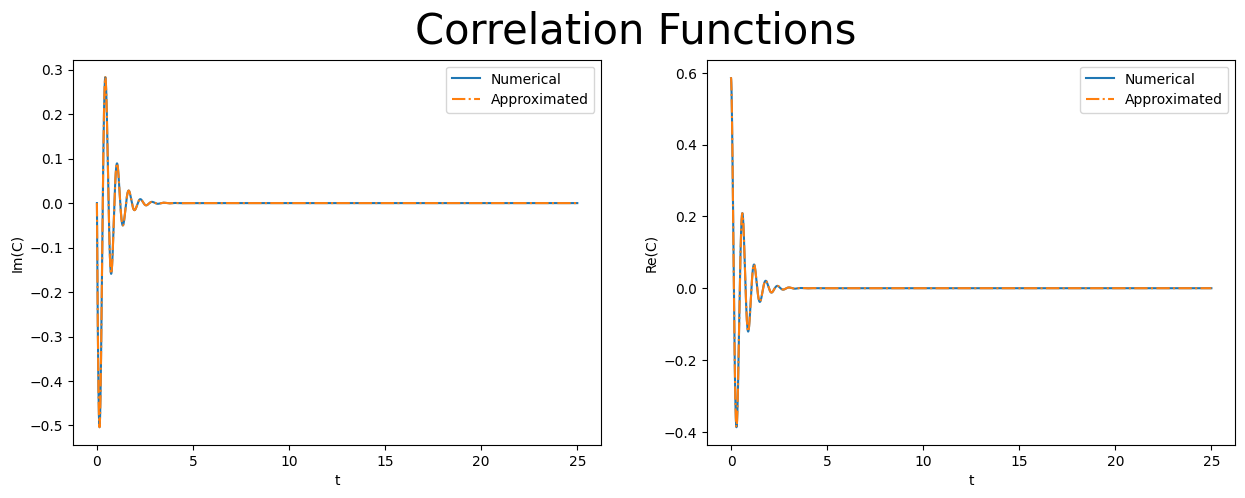

In [14]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [15]:
ans = example.evolution(rho0, Ncutoff, times, e_ops=[H], options={
                        "atol": 1e-14, "normalize_output": False, "store_states": True})
ans = [i.ptrace(range(N))for i in ans.states]

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [ ]:
from qutip import qload

In [ ]:
results=[result,result_cum,resultBR,resultBR2,ans]

In [ ]:
def plot_ground(states,H,times):
    E0=np.min(H.eigenenergies()[0])
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([(j*H).tr() for j in i.states])
        except:
            sdd=np.array([(j*H).tr() for j in i])
 
        plt.plot(times,sdd-E0,label=labels[k])
    plt.legend(fontsize=14)
    plt.yscale("log")
    plt.ylabel(r"$\langle H \rangle - E_0$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()
        

In [ ]:
plot_ground(results,H,times)

In [ ]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()
        

In [ ]:
plot_fidelities(results,H,times)

In [ ]:
def plot_trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,1-sdd,label=labels[k])
    plt.legend(fontsize=14)
    plt.yscale("log")
    plt.ylabel(r"$\mathcal{Tr}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()
        

In [ ]:
plot_trd(results,H,times)

In [ ]:
def plot_positivity(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([np.min(i.states[j].eigenenergies()) for j in range(len(times))])
        except:
            sdd=np.array([np.min(i[j].eigenenergies())  for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k])
   # plt.ylim(-1e-3,0.001)
    plt.legend(fontsize=14)
    plt.ylabel(r"$min |E_i|$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

In [ ]:
plot_positivity(results,H,times)

In [ ]:
from qutip import qsave,qload

In [ ]:
#qsave(results,f"N={N}_ising_{lam}_nocheating_goodq")